# Set up environment

In [1]:
import os

# make only specific GPU to be utilized
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# select GPU to run on
GPU = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

# stop GPU
# os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

# set GPU to be deterministic 
os.environ["PYTHONHASHSEED"] = "0" # set hash environment
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0" # use cuDNN function to retrieve the best algorithm
os.environ["TF_CUDNN_CONVOLUTION_BWD_FILTER_ALGO_DETERMINISTIC"]='1' # use cuDNN deterministic algorithms
os.environ['TF_DETERMINISTIC_OPS'] = '1' # deterministic setting

# set numpy, python, tensorflow random seed
from numpy.random import seed
import random
random.seed(10)
seed(10)
from tensorflow import set_random_seed
set_random_seed(20)

# GPU memory control
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.70
sess = tf.Session(config=config)

In [2]:
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils
from keras_gpt_2 import load_trained_model_from_checkpoint, get_bpe_from_files, generate
from keras.models import Model
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import shap

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using TensorFlow backend.


In [3]:
# #### Ref: https://github.com/openai/gpt-2

# #### Clone gpt-2 (if git does not install in jupyter notebook, clone using terminal)
# ! git clone https://github.com/openai/gpt-2.git

# #### Select directory
# cd gpt-2

# #### Install requirements
# ! pip3 install -r requirements.txt

# ######### Download model
# ! python3 download_model.py 117M
# ! python3 download_model.py 345M
# ! python3 download_model.py 774M
# ! python3 download_model.py 1558M
# cd ..

# Set up parameters

In [4]:
pad_maxlen = 20
encoding_mode = "bpe" ## "tokenize", "bpe"

# Get data

In [5]:
df_data = pd.read_csv("data/merge_data.csv")
print (df_data.dtypes)

df_data.head()

Unnamed: 0      int64
date           object
sign          float64
words          object
Open          float64
bpe            object
dtype: object


,Unnamed: 0,date,sign,words,Open,bpe
0,0,2016-01-04,1.0,"[2307, 2031, 3117, 11278, 2761, 86, 2394, 5589...",118.86,"[3281, 8153, 290, 1809, 18912, 17902, 6266, 10..."
1,1,2016-01-04,1.0,"[5, 1480, 641, 1169, 642, 8852, 3469, 524, 206...",118.86,"[385, 14420, 2121, 442, 3762, 5939, 28940, 908..."
2,2,2016-01-04,1.0,"[2, 14, 1439, 5353, 868, 8899, 762, 2425, 1649...",118.86,"[3605, 614, 28001, 33401, 5667, 39783, 36650, ..."
3,3,2016-01-04,1.0,"[7, 5706, 3227, 8659, 13, 659, 3697, 16492, 17...",118.86,"[6894, 29885, 43799, 30592, 812, 45610, 1458, ..."
4,4,2016-01-04,1.0,"[3033, 152, 2797, 453, 1517, 1746, 528, 1973, ...",118.86,"[39870, 1762, 22404, 701, 1382, 5428, 2116, 24..."


In [6]:
df_data["sign"].unique()

array([1., 2., 0.])

In [7]:
# seperate train, validate, test datasets
if encoding_mode == "tokenize":
    x_train, x_test0, y_train, y_test0 = train_test_split(
        df_data["words"].apply(eval).values, df_data["sign"].values, test_size=0.30, random_state=42, shuffle=False)
    print (len(df_data["words"].apply(eval).values))    
    x_validate, x_test, y_validate, y_test = train_test_split(
        x_test0,  y_test0, test_size=0.50, random_state=42, shuffle=False)
    print('Pad sequences (samples x time)')
    # pad sequences
    x_train = sequence.pad_sequences(x_train, maxlen=pad_maxlen)
    x_validate = sequence.pad_sequences(x_validate, maxlen=pad_maxlen)
    x_test = sequence.pad_sequences(x_test, maxlen=pad_maxlen)
    print('x_train shape:', x_train.shape)
    print('x_validate shape:', x_validate.shape)
    print('x_test shape:', x_test.shape)    
elif encoding_mode == "bpe":
    encode_data = df_data["bpe"].apply(eval).values
    x_train, x_test0, y_train, y_test0 = train_test_split(
        encode_data, df_data["sign"].values, test_size=0.33, random_state=42, shuffle=False)  
    print (len(df_data["bpe"].apply(eval).values))    
    x_validate, x_test, y_validate, y_test = train_test_split(
        x_test0,  y_test0, test_size=0.50, random_state=42, shuffle=False)
    text_lens = [len(encode) for encode in x_train]
    max_len = max(text_lens)
    print ("maxlen", max_len)  
    # pad sequence
    x_train =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_train])
    x_validate =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_validate])
    x_test =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_test])
elif encoding_mode == "text":
    encode_data = df_data["bpe"].apply(eval).values
    x_train, x_test0, y_train, y_test0 = train_test_split(
        encode_data, df_data["sign"].values, test_size=0.33, random_state=42, shuffle=False)  
    print (len(df_data["bpe"].apply(eval).values))    
    x_validate, x_test, y_validate, y_test = train_test_split(
        x_test0,  y_test0, test_size=0.50, random_state=42, shuffle=False)
    text_lens = [len(encode) for encode in x_train]
    max_len = max(text_lens)
    print ("maxlen", max_len)  
    # pad sequence
    x_train =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_train])
    x_validate =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_validate])
    x_test =  np.array([encode + [0] * (max_len - len(encode)) for encode in x_test])
    
print (x_train.shape, x_validate.shape, x_test.shape)

2459
maxlen 53
(1647, 53) (406, 53) (406, 53)


In [8]:
x_train

array([[ 3281,  8153,   290, ...,     0,     0,     0],
       [  385, 14420,  2121, ...,     0,     0,     0],
       [ 3605,   614, 28001, ...,     0,     0,     0],
       ...,
       [ 2724,  4773,   595, ...,     0,     0,     0],
       [  354,  4549, 45391, ...,     0,     0,     0],
       [19024, 21570,  2506, ...,     0,     0,     0]])

In [9]:
from sklearn.preprocessing import LabelEncoder

# Encode text to labels
le = LabelEncoder()
le.fit(y_train)
train_labels_enc = le.transform(y_train)
validation_labels_enc = le.transform(y_validate)
test_labels_enc = le.transform(y_test)

print (y_train[0:4], train_labels_enc[0:4])
print (train_labels_enc.shape, test_labels_enc.shape)

[1. 1. 1. 1.] [1 1 1 1]
(1647,) (406,)


In [10]:
from keras.utils import to_categorical

# Convert a vector label to matrix label
y_train_ohe = to_categorical(train_labels_enc)
y_validation_ohe = to_categorical(validation_labels_enc)
y_test_ohe = to_categorical(test_labels_enc)
print (y_train_ohe.shape,y_test_ohe.shape[0])

(1647, 3) 406


In [11]:
y_train_ohe

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [12]:
set(y_train)

{0.0, 1.0, 2.0}

# Common functions

In [13]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
def predict_model_confusion_matrix(x_train, y_train, model):
    
    # load best model weights
#     model.load_weights("output/fx_model.hdf5")
    
    # predict 
    predicted_labels = model.predict_classes(x_train)
    print ("predicted_labels", set(predicted_labels))
    
    true_labels = y_train
    
    # get_metrics
    print('Accuracy:', metrics.accuracy_score(true_labels, predicted_labels))
    print('Precision:', metrics.precision_score(true_labels, predicted_labels, average='weighted'))
    print('Recall:', metrics.recall_score(true_labels, predicted_labels, average='weighted'))
    print('F1 Score:', metrics.f1_score(true_labels, predicted_labels,average='weighted'))

    # confusion matrix
    labels = list(set(y_train))
    cm = confusion_matrix(y_train, predicted_labels, labels=labels)
    cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
    sns.heatmap(cm_labeled, annot=True, cmap='Greens', fmt='g')
    return true_labels, predicted_labels

def plot_confusion_matrix(true_labels, predicted_labels):
    # get_metrics
    print('Accuracy:', metrics.accuracy_score(true_labels, predicted_labels))
    print('Precision:', metrics.precision_score(true_labels, predicted_labels, average='weighted'))
    print('Recall:', metrics.recall_score(true_labels, predicted_labels, average='weighted'))
    print('F1 Score:', metrics.f1_score(true_labels, predicted_labels,average='weighted'))

    # confusion matrix
    labels = list(set(true_labels))
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
    sns.heatmap(cm_labeled, annot=True, cmap='Greens', fmt='g')
    return 

In [14]:
def plot_accuracy(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('Transfer Learning Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_lenght = len(history.history['accuracy'])+1
    epoch_list = list(range(1,epoch_lenght))
    
    # Plot accuracy
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epoch_lenght, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    # Plot loss
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epoch_lenght, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

# Get pretrained model (gpt-2)

In [15]:
# https://github.com/CyberZHG/keras-gpt-2/tree/master/keras_gpt_2

In [16]:
# Set up filename and path for loading trained model
model_folder = 'gpt-2/models/1558M' # 117M, 345M, 774M, 1558M
config_path = os.path.join(model_folder, 'hparams.json')
checkpoint_path = os.path.join(model_folder, 'model.ckpt')
encoder_path = os.path.join(model_folder, 'encoder.json')
vocab_path = os.path.join(model_folder, 'vocab.bpe')

print('Load model from checkpoint...')
# Get pretrained model for transfer learning
pretrained_model = load_trained_model_from_checkpoint(config_path, checkpoint_path)
bpe = get_bpe_from_files(encoder_path, vocab_path)

Load model from checkpoint...


In [17]:
pretrained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
Embed-Token (EmbeddingRet)      [(None, None, 1600), 80411200    Input[0][0]                      
__________________________________________________________________________________________________
Embed-Token-Pos (PositionEmbedd (None, None, 1600)   1638400     Embed-Token[0][0]                
__________________________________________________________________________________________________
Encode-0-MultiHeadAtt-Norm (Lay (None, None, 1600)   3200        Embed-Token-Pos[0][0]            
____________________________________________________________________________________________

In [18]:
# # Remove the last layer of the pretrained model
output = pretrained_model.layers[-1].output
print (output)
# output = layers.Flatten()(output)
# output = pretrained_model.output
print (pretrained_model.input)

# Freeze the model which will be extracted as a feature later
gpt2_model = Model(pretrained_model.input, output)

gpt2_model.trainable = False

# Confirm the trainable status of each layers
for layer in gpt2_model.layers:
    print(layer, layer.trainable)
    
# Show a summary of the pretrained model. Check the number of trainable parameters
gpt2_model.summary()

Tensor("Output/truediv:0", shape=(?, ?, 50257), dtype=float32)
Tensor("Input:0", shape=(?, ?), dtype=float32)
<keras.engine.input_layer.InputLayer object at 0x7f33e47a8898> False
<keras_embed_sim.embeddings.EmbeddingRet object at 0x7f33e44c0048> True
<keras_pos_embd.pos_embd.PositionEmbedding object at 0x7f33e44c0438> True
<keras_layer_normalization.layer_normalization.LayerNormalization object at 0x7f33e44c0358> True
<keras_multi_head.multi_head_attention.MultiHeadAttention object at 0x7f33e44c0160> True
<keras.layers.merge.Add object at 0x7f33e447ef60> True
<keras_layer_normalization.layer_normalization.LayerNormalization object at 0x7f33e4445550> True
<keras_position_wise_feed_forward.feed_forward.FeedForward object at 0x7f33e4196a90> True
<keras.layers.merge.Add object at 0x7f33e415a6d8> True
<keras_layer_normalization.layer_normalization.LayerNormalization object at 0x7f33e4122710> True
<keras_multi_head.multi_head_attention.MultiHeadAttention object at 0x7f33e41226d8> True
<keras

In [19]:
x_train.shape, y_train.shape

((1647, 53), (1647,))

In [20]:
from keras.models import Sequential
from keras import optimizers, losses
from keras import layers
from keras.layers import LSTM, Embedding
import keras.backend as K

# # Create the model
model = Sequential()

# # Add the pretrained model
model.add(gpt2_model)

# # Add new layers
model.add(layers.Lambda(lambda x: K.mean(x, axis=1)))
model.add(layers.Dense(y_train_ohe.shape[1], activation='relu'))

# Compile model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Show model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, None, 50257)       1557611200
_________________________________________________________________
lambda_1 (Lambda)            (None, 50257)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 150774    
Total params: 1,557,761,974
Trainable params: 150,774
Non-trainable params: 1,557,611,200
_________________________________________________________________


In [21]:
print (x_train.shape, y_train.shape, y_train_ohe.shape)
print (x_validate.shape, y_validate.shape, y_validation_ohe.shape)
print (x_test.shape, y_test.shape, y_test_ohe.shape)

(1647, 53) (1647,) (1647, 3)
(406, 53) (406,) (406, 3)
(406, 53) (406,) (406, 3)


In [22]:
epochs = 25
batch_size = pad_maxlen * 10

filepath = "output/fx_model.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)
callbacks_list = [checkpoint]

# Train the model
start = time.time()
gpt2_history = model.fit(x=x_train, y=y_train_ohe,
                         validation_data=(x_validate, y_validation_ohe),
                         batch_size=batch_size,
                         epochs=epochs,
                         callbacks=callbacks_list
                        )

end = time.time()
print ("calculation time: ", end - start)

W1222 23:52:24.924253 139869727029056 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1222 23:52:28.090173 139869727029056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 1647 samples, validate on 406 samples
Epoch 1/25
1647/1647 [==============================] - 45s 27ms/step - loss: 1.4455 - accuracy: 0.4894 - val_loss: 0.8170 - val_accuracy: 0.4581

Epoch 00001: val_accuracy improved from -inf to 0.45813, saving model to output/fx_model.hdf5
Epoch 2/25
1647/1647 [==============================] - 33s 20ms/step - loss: 0.7812 - accuracy: 0.5082 - val_loss: 0.8275 - val_accuracy: 0.4310

Epoch 00002: val_accuracy did not improve from 0.45813
Epoch 3/25
1647/1647 [==============================] - 33s 20ms/step - loss: 0.7796 - accuracy: 0.5021 - val_loss: 0.8254 - val_accuracy: 0.4310

Epoch 00003: val_accuracy did not improve from 0.45813
Epoch 4/25
1647/1647 [==============================] - 34s 20ms/step - loss: 0.7754 - accuracy: 0.5082 - val_loss: 0.8216 - val_accuracy: 0.4261

Epoch 00004: val_accuracy did not improve from 0.45813
Epoch 5/25
1647/1647 [==============================] - 34s 20ms/step - loss: 0.7712 - accuracy: 0.5288 - 

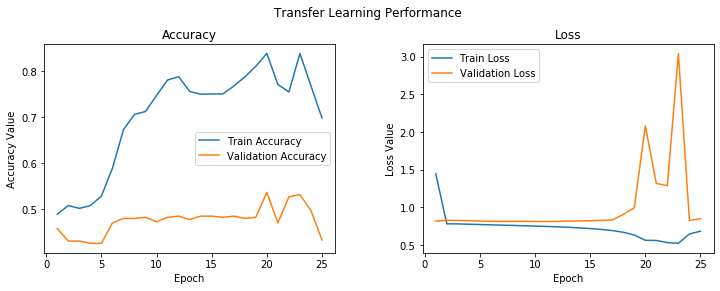

In [23]:
plot_accuracy(gpt2_history)

# predict model

In [24]:
# use model weight from the best validation accuracy
model.load_weights(filepath)

predicted_labels {0, 1, 2}
Accuracy: 0.8554948391013965
Precision: 0.8561816419097822
Recall: 0.8554948391013965
F1 Score: 0.8533462141542991


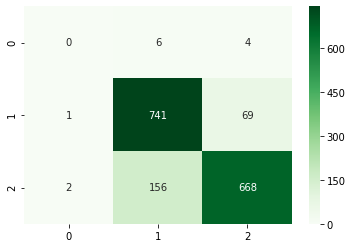

In [25]:
true_train, predicted_train = predict_model_confusion_matrix(x_train, np.argmax(y_train_ohe,1), model)

predicted_labels {0, 1, 2}
Accuracy: 0.5369458128078818
Precision: 0.5381171395547238
Recall: 0.5369458128078818
F1 Score: 0.5374791605247323


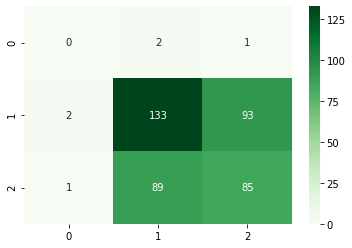

In [26]:
true_validate, predicted_validate =predict_model_confusion_matrix(x_validate, np.argmax(y_validation_ohe,1), model)

predicted_labels {0, 1, 2}
Accuracy: 0.5246305418719212
Precision: 0.5280431310142182
Recall: 0.5246305418719212
F1 Score: 0.5253796985969326


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


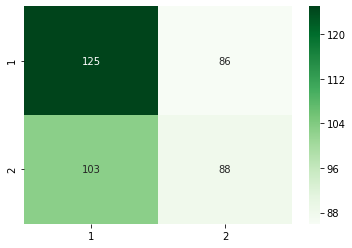

In [27]:
true_test, predicted_test =predict_model_confusion_matrix(x_test, np.argmax(y_test_ohe,1), model)

In [28]:
x_train

array([[ 3281,  8153,   290, ...,     0,     0,     0],
       [  385, 14420,  2121, ...,     0,     0,     0],
       [ 3605,   614, 28001, ...,     0,     0,     0],
       ...,
       [ 2724,  4773,   595, ...,     0,     0,     0],
       [  354,  4549, 45391, ...,     0,     0,     0],
       [19024, 21570,  2506, ...,     0,     0,     0]])

# Combine data

In [29]:
df_process = df_data[["date","sign"]]
df_process["sign"] = np.where(df_process["sign"]==2.0, -1,df_process["sign"])
df_process.count()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


date    2459
sign    2459
dtype: int64

In [30]:
df_impact = df_process.groupby("date").sum().reset_index()
df_impact.count()

date    508
sign    508
dtype: int64

In [31]:
print (x_train.shape, x_test.shape, x_validate.shape)
print (x_train.shape[0]+x_test.shape[0]+x_validate.shape[0])

(1647, 53) (406, 53) (406, 53)
2459


In [32]:
len(true_train), len(predicted_train)

(1647, 1647)

In [33]:
df_train = df_process[0:x_train.shape[0]]
df_validate = df_process[x_train.shape[0]:x_train.shape[0]+x_validate.shape[0]]
df_test = df_process[x_train.shape[0]+x_validate.shape[0]:x_train.shape[0]+x_validate.shape[0]+x_test.shape[0]]

In [34]:
df_train["true"] = true_train
df_train["predict"] = predicted_train
df_validate["true"] = true_validate
df_validate["predict"] = predicted_validate
df_test["true"] = true_test
df_test["predict"] = predicted_test
df_train["true"] = np.where(df_train["true"]==2.0, -1,df_train["true"])
df_validate["true"] = np.where(df_validate["true"]==2.0, -1,df_validate["true"])
df_test["true"] = np.where(df_test["true"]==2.0, -1,df_test["true"])
df_train["predict"] = np.where(df_train["predict"]==2.0, -1,df_train["predict"])
df_validate["predict"] = np.where(df_validate["predict"]==2.0, -1,df_validate["predict"])
df_test["predict"] = np.where(df_test["predict"]==2.0, -1,df_test["predict"])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

In [35]:
df_train2 = df_train.groupby("date").sum().reset_index()
df_validate2 = df_validate.groupby("date").sum().reset_index()
df_test2 = df_test.groupby("date").sum().reset_index()

In [36]:
df_train2["true_sign"] = np.sign(df_train2['true'])
df_validate2["true_sign"] = np.sign(df_validate2['true'])
df_test2["true_sign"] = np.sign(df_test2['true'])
df_train2["predict_sign"] = np.sign(df_train2['predict'])
df_validate2["predict_sign"] = np.sign(df_validate2['predict'])
df_test2["predict_sign"] = np.sign(df_test2['predict'])
df_train2.head(2)

,date,sign,true,predict,true_sign,predict_sign
0,2016-01-04,5.0,5,3,1,1
1,2016-01-05,-5.0,-5,-1,-1,-1


In [37]:
len(df_train2["true_sign"].values), len(df_train2["predict_sign"].values)

(285, 285)

Accuracy: 0.9403508771929825
Precision: 0.9659605528635223
Recall: 0.9403508771929825
F1 Score: 0.9511988304093568


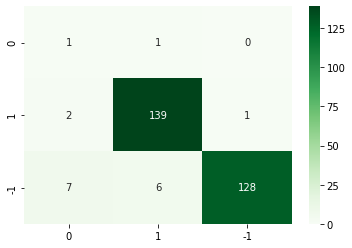

In [38]:
plot_confusion_matrix(df_train2["true_sign"].values, df_train2["predict_sign"].values)

Accuracy: 0.43333333333333335
Precision: 0.5241821396993811
Recall: 0.43333333333333335
F1 Score: 0.47279967445645854


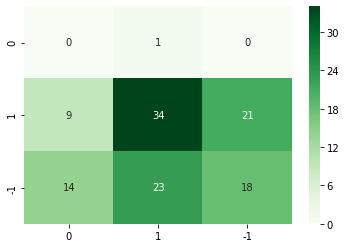

In [39]:
plot_confusion_matrix(df_validate2["true_sign"].values, df_validate2["predict_sign"].values)

Accuracy: 0.42857142857142855
Precision: 0.5289795918367347
Recall: 0.42857142857142855
F1 Score: 0.4706655075823432


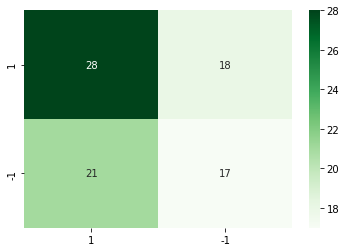

In [40]:
plot_confusion_matrix(df_test2["true_sign"].values, df_test2["predict_sign"].values)